# Notebook for plotting error barriers

In [1]:
REPLICATES = 5
layer_idx_to_depth = {
    "cifar_vgg_16_64": {
        "0": 1,
        "1": 2,
        "3": 3,
        "4": 4,
        "6": 5,
        "7": 6,
        "8": 7,
        "10": 8,
        "11": 9,
        "12": 10,
        "14": 11,
        "15": 12,
        "16": 13,
        "fc": 14,
    },
    "cifar_resnet_20_64": {
        "0": 2,
        "1": 3,
        "2": 4,
        "3": 5,
        "4": 6,
        "5": 7,
        "6": 8,
        "7": 9,
        "8": 10,
        "fc": 11,
    }
}
models = {
    "lottery_8146fc7e9839615729ee764a8019bdc5": "cifar_vgg_16_64",
    "lottery_0683974d98b4b6cb906aa0b80db9e2f5": "cifar_resnet_20_64",
}

from itertools import product
import pandas as pd
from pathlib import Path
import numpy as np

def first_matching_substr(string, delimiter, starts=[""], strip=False):
    for part in string.split(delimiter):
        if not isinstance(starts, list):
            starts = [starts]
        for start in starts:
            if part.startswith(start):
                return part[len(start):] if strip else part
    return None

def to_int_if_exists(string):
    try:
        return int(string)
    except:
        return None

def median_if_existing(string):
    splits = string.split(",")
    if len(splits) > 1:
        array = [to_int_if_exists(first_matching_substr(i, "_", "ep", True)) for i in string.split(",")]
        if not any(x is None for x in array):
            return np.median(np.array(array))
    return None

def convert_column_to_epoch(df, column):
    df[column + ".epoch"] = df[column].apply(
        lambda x: to_int_if_exists(first_matching_substr(x, "_", "ep", True)))

def get_all_thresholds(dataframe):
    depths = []
    for i, row in dataframe.iterrows():
        depth = layer_idx_to_depth[row["model.name"]].get(row["threshold"], None)
        depths.append(depth)
    return depths

# preprocess and make useful columns
df = pd.read_csv("../refactor-outputs/barriers.csv")
filters = (df["interpolation"] == 25)
df = df.loc[filters]
df["train"] = df["type"].str.startswith("train")
df["barrier"] = df["type"].apply(lambda x: "-".join(x.split("-")[1:]))
df["perm"] = df["path"].apply(lambda x:  first_matching_substr(Path(x).stem, "-", "ep"))
convert_column_to_epoch(df, "barrier")
convert_column_to_epoch(df, "perm")
df["model"] = df["path"].apply(lambda x: first_matching_substr(x, "/", "lottery_"))
df["model.name"] = df["model"].apply(lambda x: models.get(x, None))
df["replicate"] = df["path"].apply(lambda x: first_matching_substr(x, "/", "replicate_", True))
df["layersplit_type"] = df["path"].apply(lambda x: "-".join(Path(x).stem[len("barrier-perm-linear-"):].split("-")[1:-1]))
df["threshold"] = df["path"].apply(lambda x: Path(x).stem.split("-")[-1])
df["threshold.depth"] = get_all_thresholds(df)
df["align_bias"] = df["path"].str.contains("bias")
df["super_align"] = df["path"].str.contains("super")
df["acc_barrier"] = -1 * df["acc_barrier"]
df["num_combined"] = df["perm"].apply(lambda x: len(x.split(",")))
df["combined_first"] = df["perm"].apply(lambda x: x.split(",")[0])
df["combined_last"] = df["perm"].apply(lambda x: x.split(",")[-1])
convert_column_to_epoch(df, "combined_first")
convert_column_to_epoch(df, "combined_last")
df["combined_avg"] = df["perm"].apply(lambda x: median_if_existing(x))
# get the subdirectory name
df["subdir"] = df["path"].apply(lambda x: x.split("/")[7])
# trainonly (testonly) runs only have meaningful train (test) data, so remove the opposite
trainonly_with_test = (df["path"].str.contains("trainonly")) & ~(df["train"])
df = df[~(trainonly_with_test)]
testonly_with_train = (df["path"].str.contains("testonly")) & (df["train"])
df = df[~(testonly_with_train)]

all_replicates = sorted(df["replicate"].unique(), key=lambda x: int(x.split("-")[0]))
all_perm_epochs = np.sort(np.array(df["perm.epoch"].unique()))

In [2]:
# plotting code
import matplotlib.pyplot as plt
import seaborn as sns

def finalize_plot(fig, shape=(1, 1)):
    plt.gcf().set_size_inches(
        shape[0] * 1. * plt.gcf().get_size_inches()[1], 
        shape[1] * 1. * plt.gcf().get_size_inches()[1])
    fig.tight_layout()
    plt.legend()
    return fig

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

def column_stats(dfs_by_replicate, column):
    array = np.stack([np.stack([array for array in df[column]]) for df in dfs_by_replicate])
    # quantiles = np.quantile(array, [0, 0.25, 0.5, 0.75, 1.], axis=0)
    return {
        "mean": np.mean(array, axis=0),
        "std": np.std(array, axis=0),
        # "min": quantiles[0],
        # "low_quartile": quantiles[1],
        # "median": quantiles[2],
        # "high_quartile": quantiles[3],
        # "max": quantiles[4],
    }

def replicate_mean_std(df, max_replicates):
    dfs_by_replicate = []
    for replicate in all_replicates[:max_replicates]:
        rep = df[df["replicate"] == replicate]
        if len(rep) > 0:
            dfs_by_replicate.append(rep)
    assert all([len(x) == len(dfs_by_replicate[0]) for x in dfs_by_replicate])
    # get stats
    new_df = {}
    for column in df.columns:
        new_column = dfs_by_replicate[0][column] # copy values from first replicate
        first_item = df[column].iloc[0]
        if isinstance(first_item, list):
            if isinstance(first_item[0], int) or isinstance(first_item[0], float):
                stats = column_stats(dfs_by_replicate, column)
                for k, v in stats.items():
                    arrays = [list(arr) for arr in v]
                    new_df[f"{column}.{k}"] = arrays
        new_df[column] = new_column
    return pd.DataFrame(new_df)

def get_linestyle(info, fill=False):
    palette = sns.color_palette(n_colors=len(all_perm_epochs) * 2)
    replicate = info["replicate"]
    perm_epoch = info["perm.epoch"]
    super_align = info["super_align"]
    train = info["train"]
    bias = info["align_bias"]
    layersplit_type = info["layersplit_type"]
    perm_epoch_idx = np.where(all_perm_epochs == perm_epoch)[0][0]
    label = ("$P_{" + str(perm_epoch) + "}$")
    if super_align:
        perm_epoch_idx += len(all_perm_epochs)
        label = "super " + label
    if layersplit_type == "bottom-up" or layersplit_type == "top-down":
        label = layersplit_type + " " + label
    style = {
        "color": palette[perm_epoch_idx],
        "marker": "." if bias else "x",
        "linestyle": "solid" if train else "dotted",
        "linewidth": 4 if layersplit_type == "bottom-up" else 2 if layersplit_type == "top-down" else 1,
        "alpha": 0.3 if layersplit_type == "bottom-up" else 0.6 if layersplit_type == "top-down" else 1,
        "label": label if (replicate == "1-2" and train and bias) else None,
    }
    if fill:
        style["alpha"] = 0.07 if train else 0.2
        style["linewidth"] = 0
        del style["linestyle"]
        del style["marker"]
        del style["label"]
    return style

def plot_barriers(ax, data, xcol, ycol,
                  title=None, xlab=None, ylab=None, ylim=None,
                  styling_fn=get_linestyle, sort_col="perm.epoch",
                  summarize_replicates=None, train=None, align_bias=None,
                  confidence_interval=2.776):  # defaults to T distribution with df=5-1
    if train is not None:
        data = data[data["train"] == train]
    if align_bias is not None:
        data = data[data["align_bias"] == align_bias]
    data = data.sort_values(sort_col)
    if summarize_replicates is not None:
        data = replicate_mean_std(data, summarize_replicates)
    for i, row in data.iterrows():
        if summarize_replicates is not None:
            x = np.array(row[xcol + ".mean"])
            y = np.array(row[ycol + ".mean"])
            std_y = np.array(row[ycol + ".std"])
            bound = confidence_interval * std_y / np.sqrt(summarize_replicates)
            idx = np.argsort(x)
            ax.fill_between(x[idx], y[idx] - bound[idx], y[idx] + bound[idx], **styling_fn(row, True))
        else:
            x = np.array(row[xcol])
            y = np.array(row[ycol])
            bound = np.zeros_like(y)
            idx = np.argsort(x)
        ax.plot(x[idx], y[idx], **styling_fn(row))
    ax.set_xlabel(xcol if xlab is None else xlab)
    ax.set_ylabel(ycol if ylab is None else ylab)
    if title is not None:
        ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(ylim)

In [3]:
print(df.columns, len(df), all_perm_epochs, all_replicates)
for subdir in sorted(df["subdir"].unique()):
    print(subdir, len(df[df["subdir"] == subdir]))

Index(['Unnamed: 0', 'path', 'type', 'interpolation', 'eval_loss', 'acc',
       'loss_barrier', 'acc_barrier', 'interpolation.idx', 'eval_loss.idx',
       'acc.idx', 'loss_barrier.idx', 'acc_barrier.idx', 'train', 'barrier',
       'perm', 'barrier.epoch', 'perm.epoch', 'model', 'model.name',
       'replicate', 'layersplit_type', 'threshold', 'threshold.depth',
       'align_bias', 'super_align', 'num_combined', 'combined_first',
       'combined_last', 'combined_first.epoch', 'combined_last.epoch',
       'combined_avg', 'subdir'],
      dtype='object') 15703 [  1   2   3   4   5   6   8  10  20  30  50  70  80  90 110 150] ['1-2', '3-4', '5-6', '7-8', '9-10']
barrier 1260
barrier-bias 1260
barrier-endtestonly 850
barrier-endtestonly-bias 850
barrier-endtrainonly 850
barrier-endtrainonly-bias 850
barrier-endtraintest 1184
barrier-endtraintest-bias 4920
super-align-barrier 180
super-align-barrier-bias 180
super-align-barrier-endtraintest-bias 160
super-align-barrier-testonly-bias 32

In [4]:
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

def get_baseline(model, train, bias, barrier_ep=None, perm_ep=None):
    if barrier_ep == 150:
        baseline = df[df["subdir"].isin(["barrier-endtestonly", "barrier-endtestonly-bias", "barrier-endtrainonly", "barrier-endtrainonly-bias", "barrier-endtraintest", "barrier-endtraintest-bias"])]
    else:
        baseline = df[df["subdir"].isin(["barrier", "barrier-bias"])]
    baseline = baseline[baseline["layersplit_type"].isin(["final", "ckpt"])]
    baseline = baseline[baseline["model.name"] == model]
    baseline = baseline[baseline["train"] == train]
    baseline = baseline[baseline["align_bias"] == bias]
    if perm_ep is not None:
        baseline = baseline[baseline["perm.epoch"] == perm_ep]
    if barrier_ep is not None:
        baseline = baseline[baseline["barrier.epoch"] == barrier_ep]
    return baseline

<AxesSubplot:xlabel='perm.epoch', ylabel='acc_barrier'>

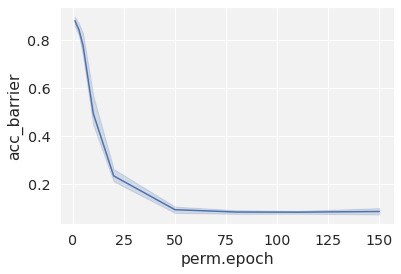

In [5]:
tmpbaseline = get_baseline("cifar_resnet_20_64", True, True, barrier_ep=150)
sns.lineplot(tmpbaseline, x="perm.epoch", y="acc_barrier")

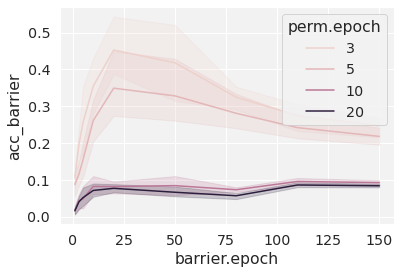

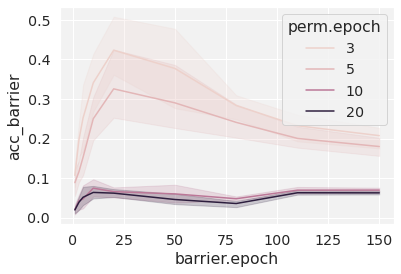

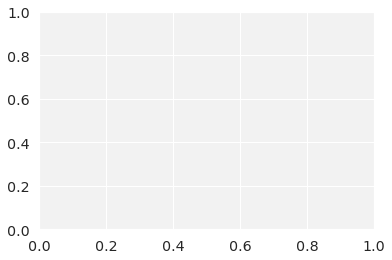

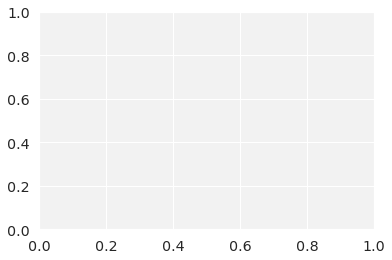

In [6]:
# split-epoch over training
filtered_df = df[df["subdir"].isin(["barrier", "barrier-bias",])]
filtered_df = filtered_df[filtered_df["align_bias"]]
filtered_df = filtered_df[filtered_df["layersplit_type"] == "top-down"]
for train, model in [(True, "cifar_vgg_16_64"), (False, "cifar_vgg_16_64"), (True, "cifar_resnet_20_64"), (False, "cifar_resnet_20_64")]:
    subset = filtered_df[(filtered_df["train"] == train) & (filtered_df["model.name"] == model)]
    fig = sns.lineplot(data=subset, x="barrier.epoch", y="acc_barrier", hue="perm.epoch")
    plt.show()

cifar_vgg_16_64 150 True
cifar_vgg_16_64 150 True
cifar_vgg_16_64 150 False
cifar_vgg_16_64 150 False
cifar_resnet_20_64 150 True
cifar_resnet_20_64 150 True
cifar_resnet_20_64 150 False
cifar_resnet_20_64 150 False


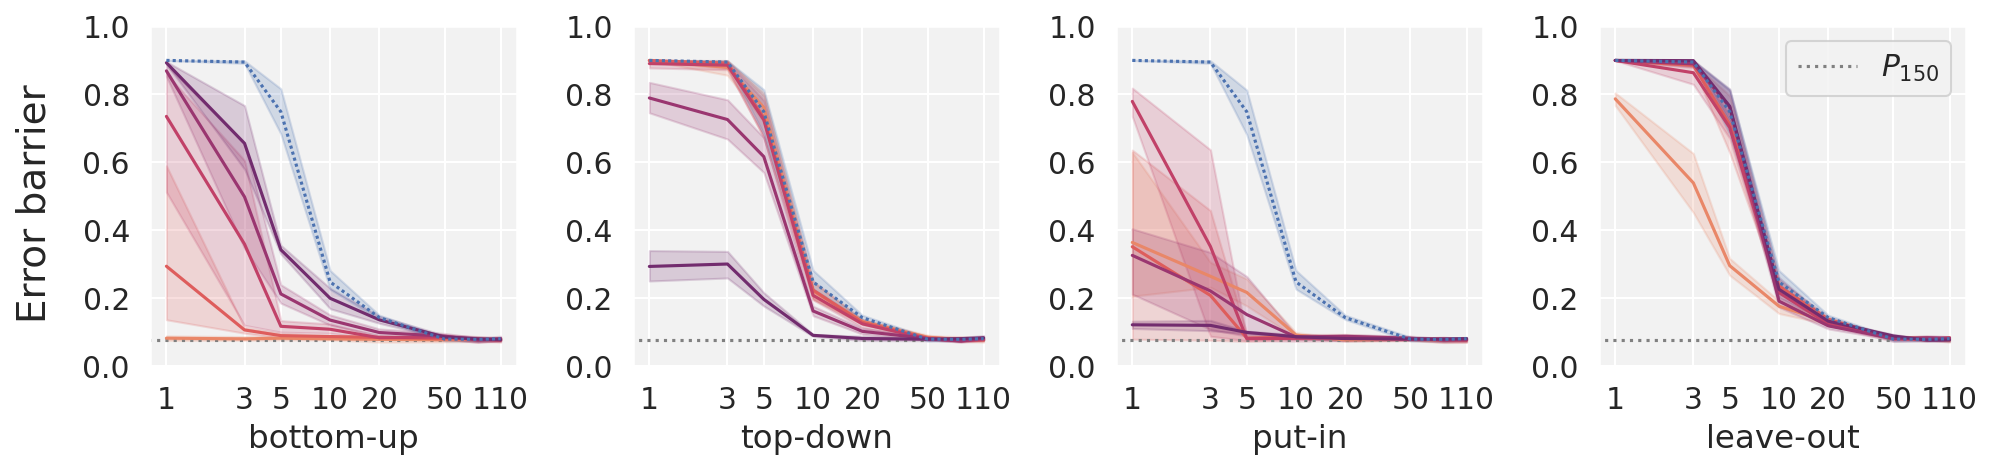

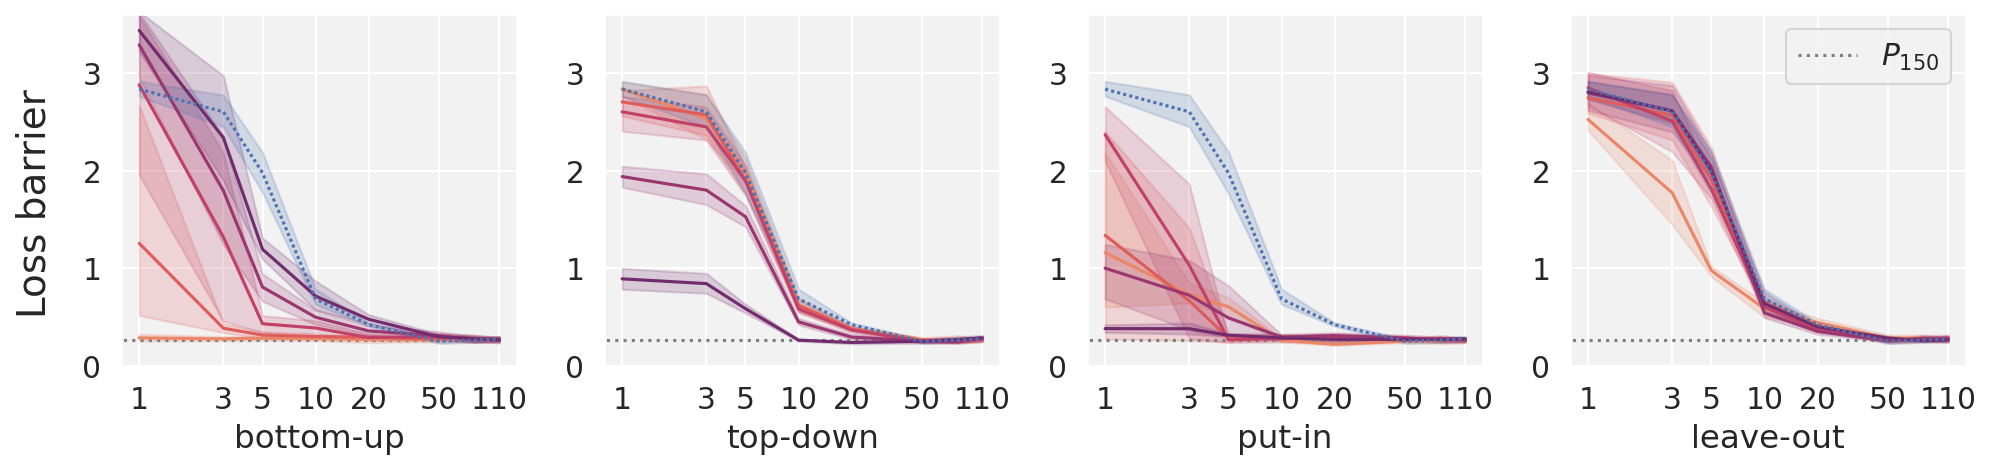

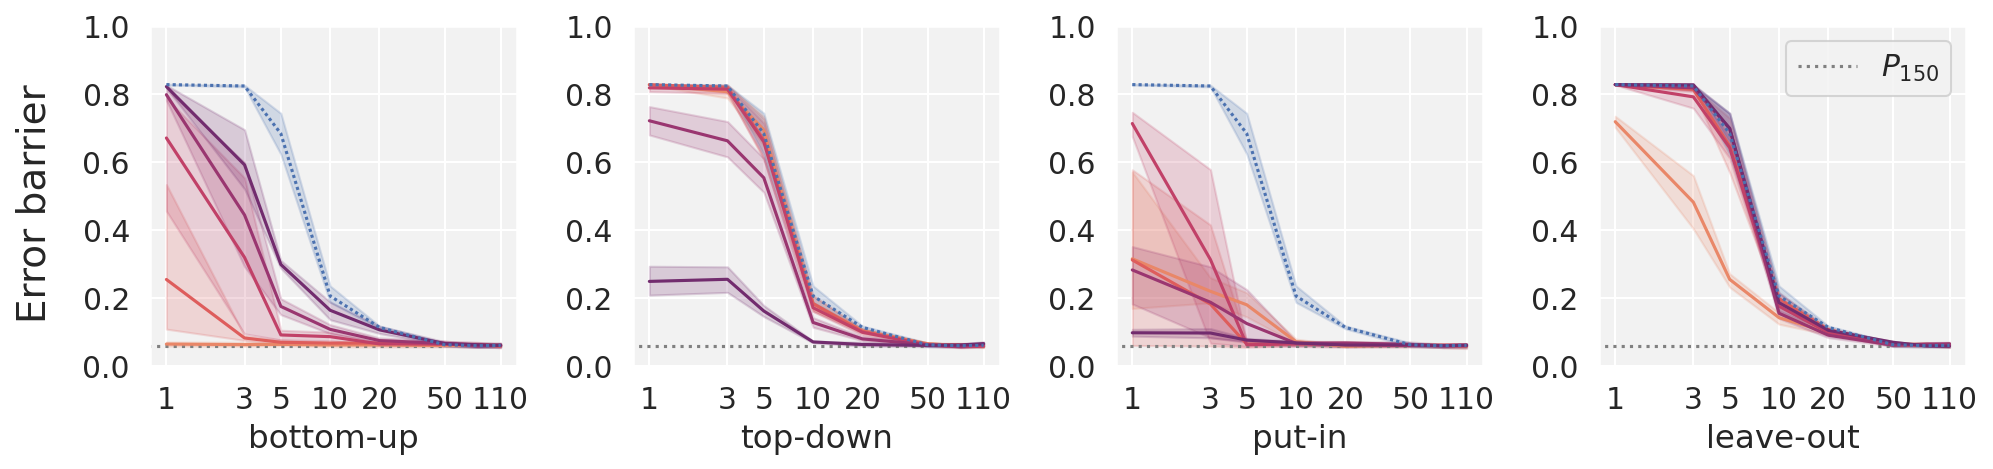

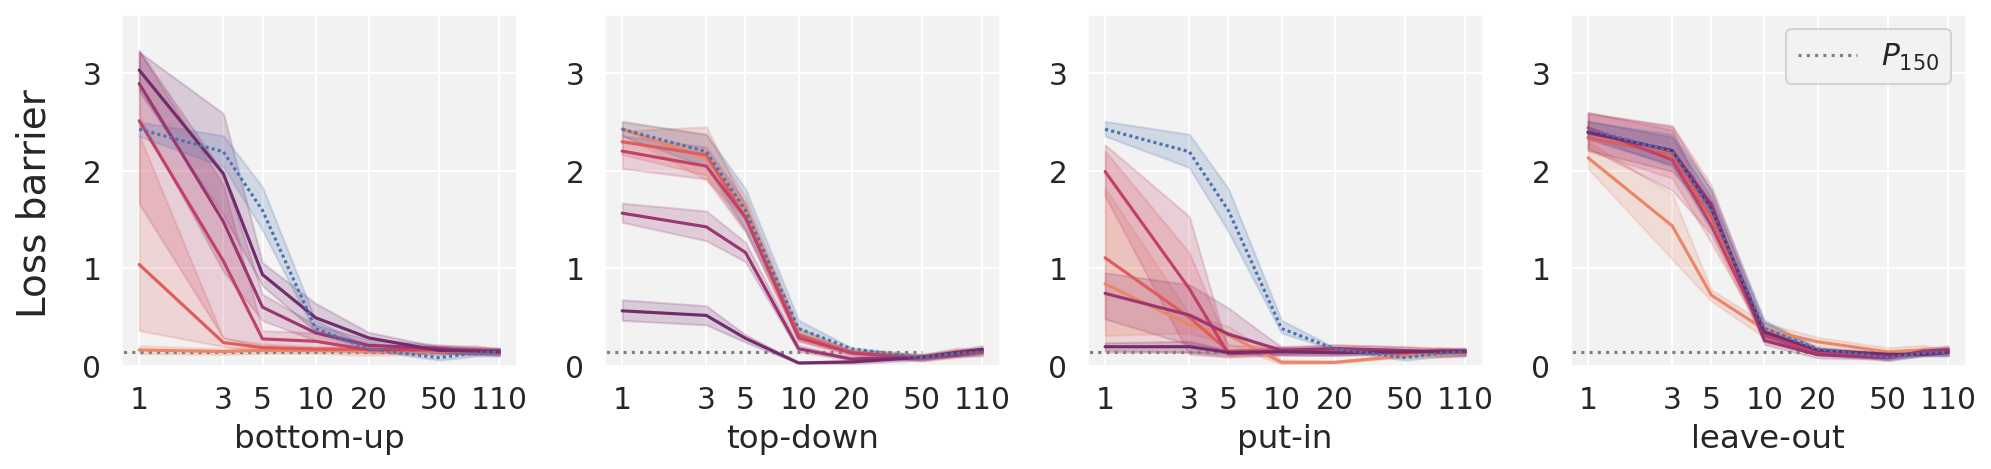

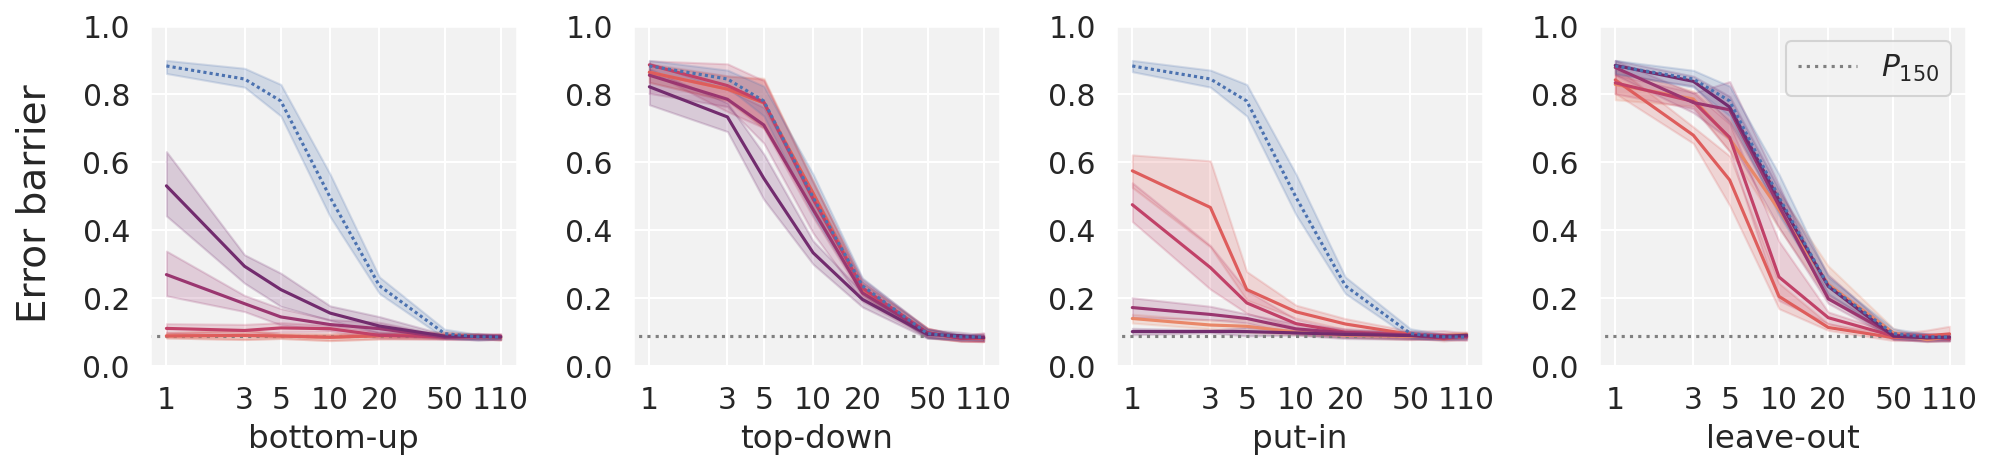

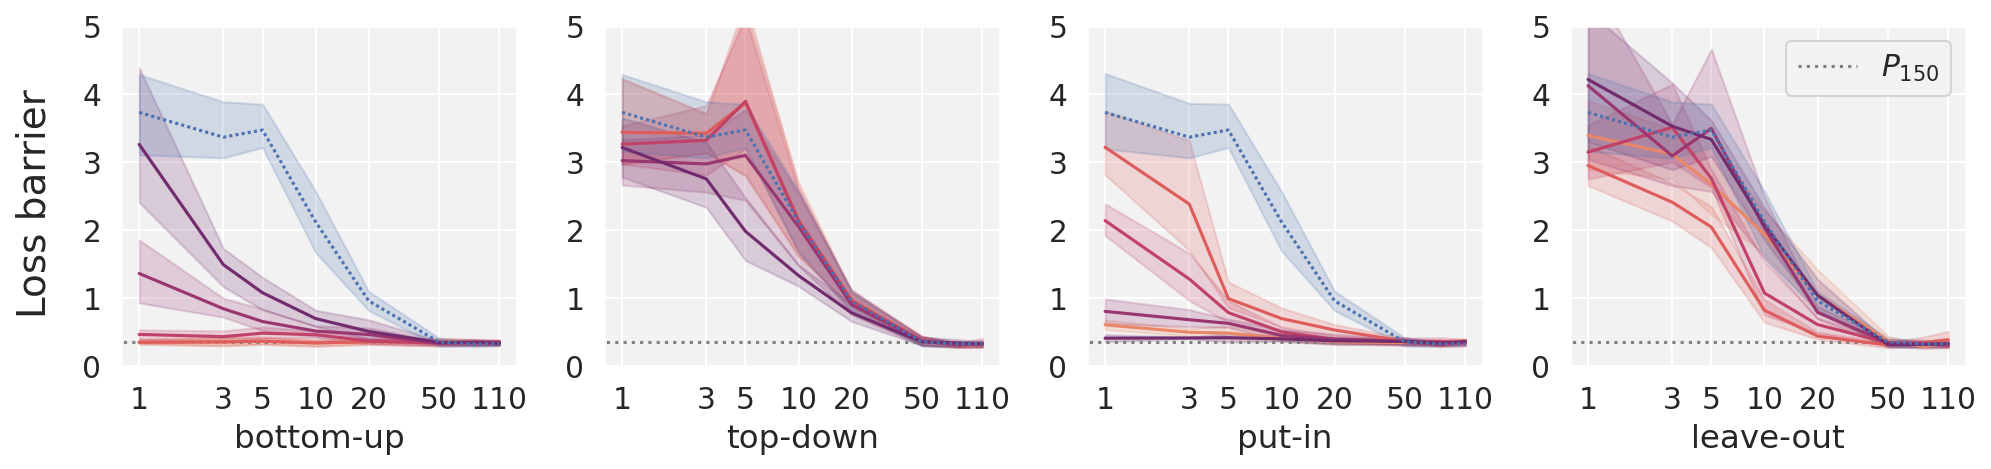

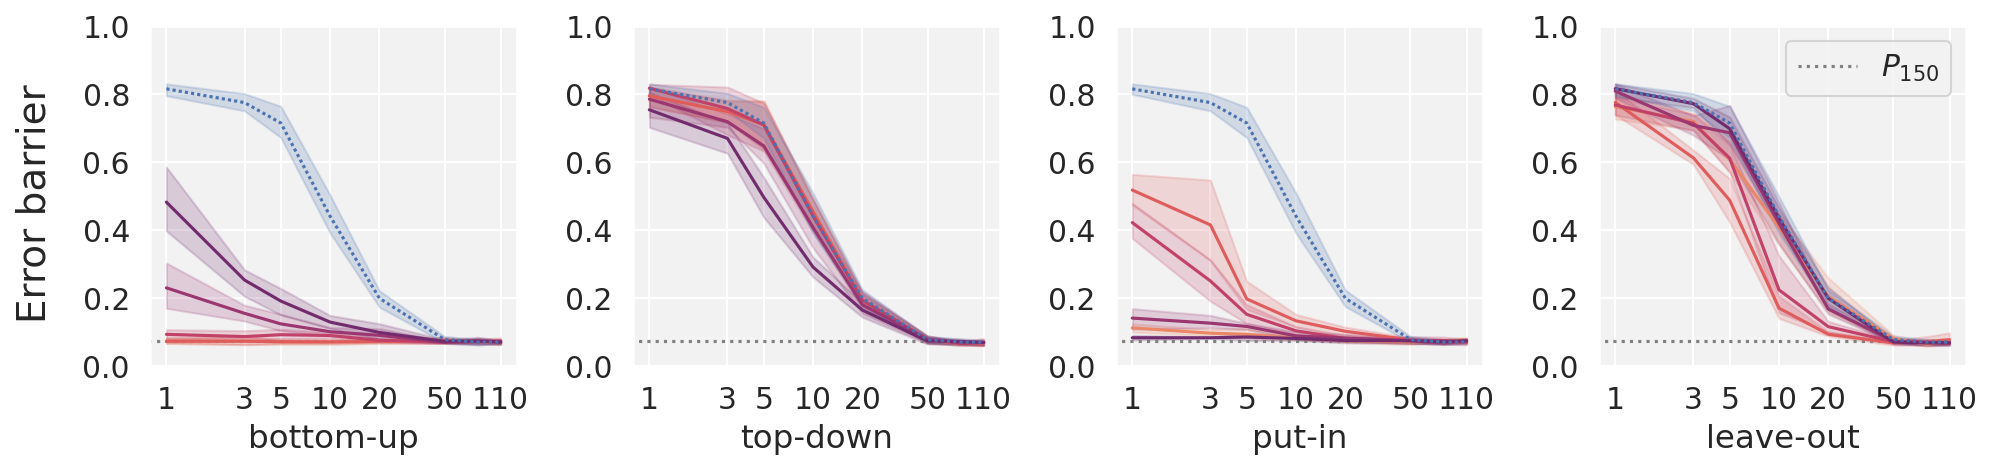

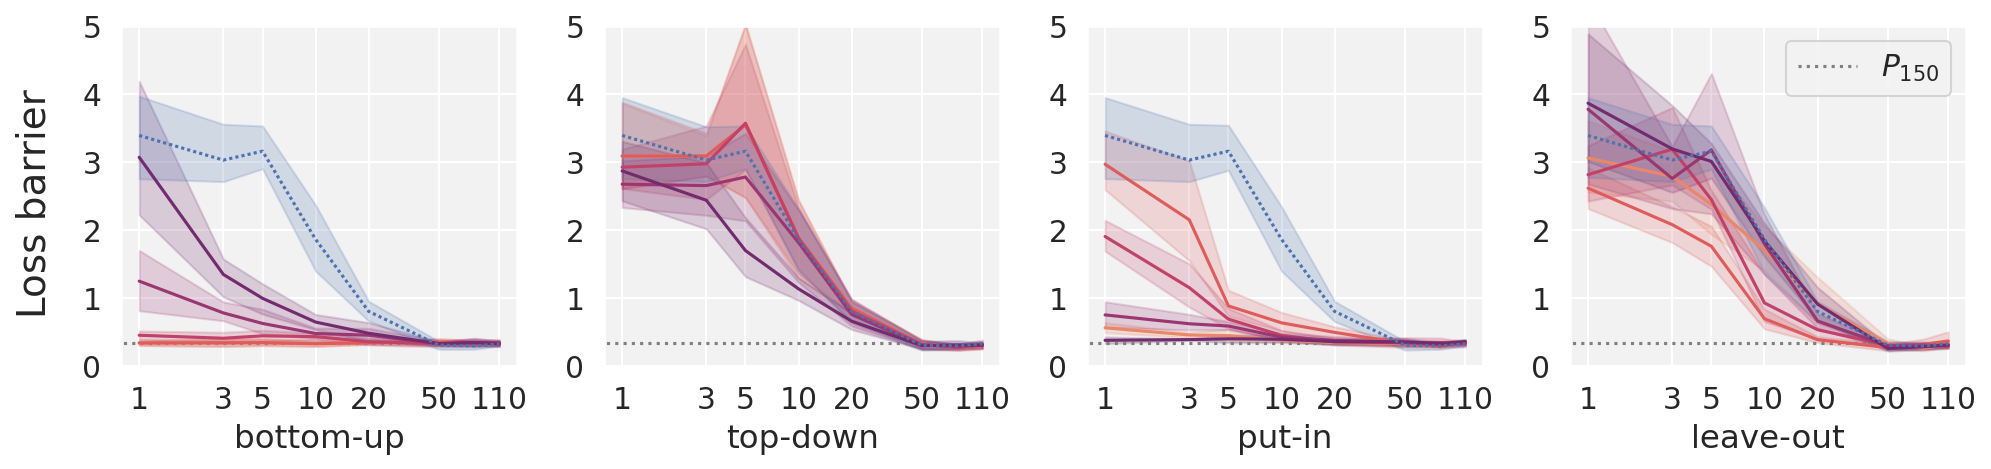

In [14]:
# split-epoch end of training
palette = sns.color_palette("flare", 5)
baseline_color = sns.color_palette(palette=None, n_colors=1)

filtered_df = df[df["subdir"].isin(["barrier-endtestonly-bias", "barrier-endtraintest-bias", "barrier-endtrainonly-bias", "barrier-endtraintest-bias"])]
filtered_df = filtered_df[filtered_df["align_bias"] == True]
# filtered_df = filtered_df[filtered_df["perm.epoch"] < 80]
depths = [int(x) for x in sorted(filtered_df["threshold.depth"].unique())[:-1]]

for model, epoch, train, plot_type in product(["cifar_vgg_16_64", "cifar_resnet_20_64"], [150], [True, False], ["acc_barrier", "loss_barrier"]):
    print(model, epoch, train)
    subset = filtered_df[(filtered_df["train"] == train) & (filtered_df["model.name"] == model) & (filtered_df["barrier.epoch"] == epoch)]

    fig, axes = plt.subplots(1,  4, figsize=(14, 3.4), dpi=150)

    baseline = get_baseline(model, train, True, barrier_ep=epoch)
    baseline = baseline[baseline["perm.epoch"] < 150]
    baseline_last_ep = get_baseline(model, train, True, barrier_ep=150, perm_ep=150)

    for ax, split_type in zip(axes, ["bottom-up", "top-down", "put-in", "leave-out"]):
        data = subset[subset["layersplit_type"] == split_type]
        legend = False # "full" if split_type == "leave-out" else False
        sns.lineplot(data=data, x="perm.epoch", y=plot_type, hue="threshold.depth", palette=palette, legend=legend, ax=ax)
        if epoch == 150:
            sns.lineplot(data=baseline, x="perm.epoch", y=plot_type, hue="barrier.epoch", palette=baseline_color, style="barrier.epoch", dashes=[(1, 1)], legend=legend, ax=ax)
        ax.hlines(np.mean(baseline_last_ep[plot_type]), 0, 50, linestyle="dotted", color="grey", label="$P_{150}$")
        ax.set(xscale='log')
        ax.set(xticks=[1, 3, 5, 10, 20, 50, 110])
        ax.set(xticklabels=[1, 3, 5, 10, 20, 50, 110])
        # ax.set(xticks=np.arange(0, 160, 25))
        ymax = 1. if plot_type == "acc_barrier" else (3.6 if model == "cifar_vgg_16_64" else 5.)
        ax.set_ylim(0., ymax)
        ax.set_ylabel("")
        ax.set_xlabel(split_type)
    # fig.supxlabel("Partial rewind epoch")
    fig.supylabel("     Error barrier" if plot_type == "acc_barrier" else "     Loss barrier")
    finalize_plot(fig, shape=(4,1))
    plt.savefig(f"../figures/{model}-{epoch}-{train}-{plot_type}.pdf")

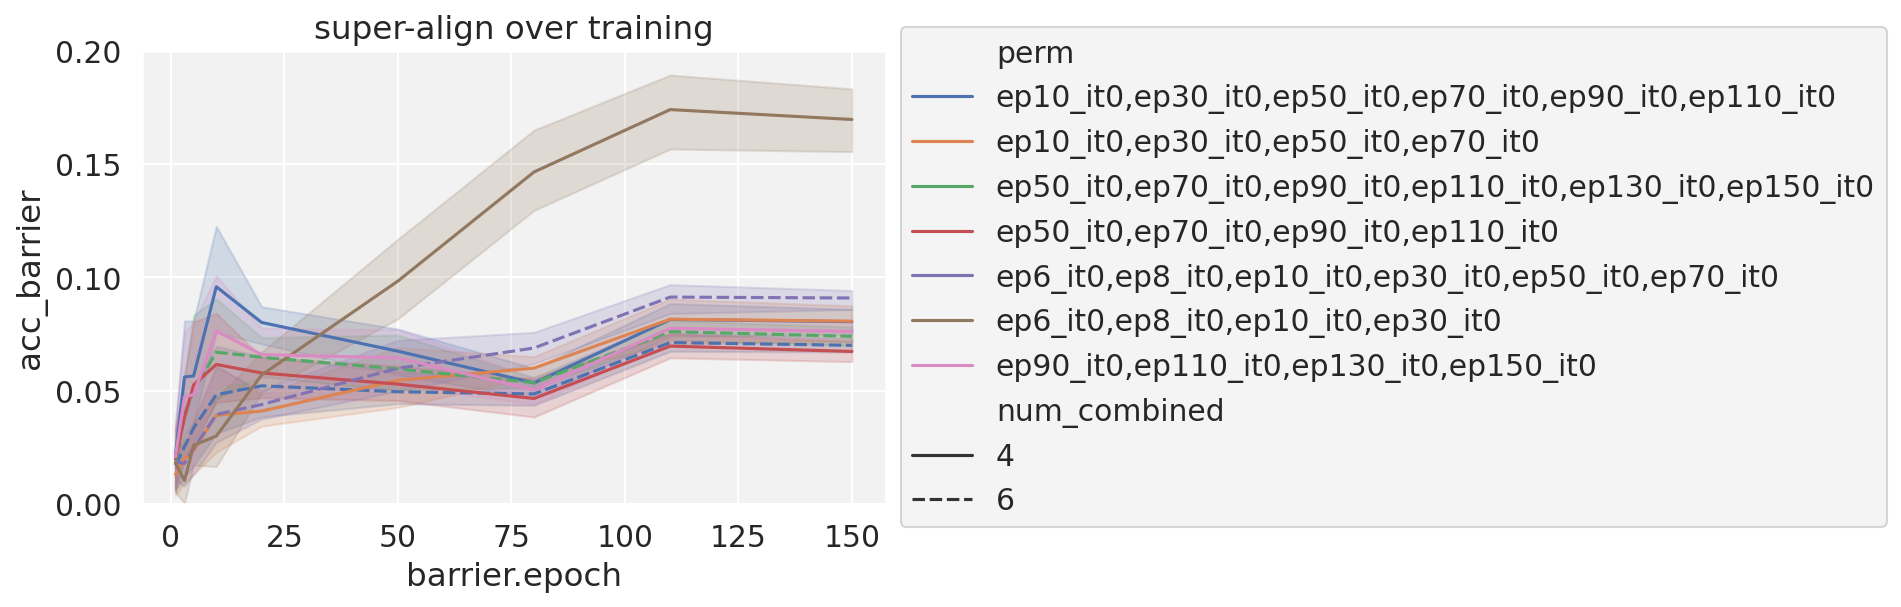

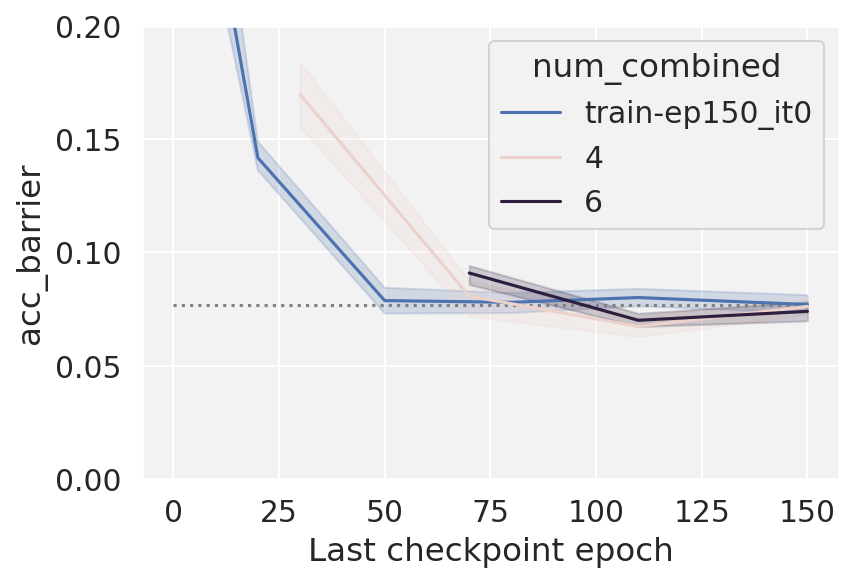

In [11]:
# super-align end of training
model = "cifar_vgg_16_64"
train = True
filtered_df = df[df["subdir"].isin(["super-align-barrier-testonly-bias",
                                    "super-align-barrier-testonly-reg",
                                    "super-align-barrier-trainonly-bias",
                                    "super-align-barrier-trainonly-reg",])]
filtered_df = filtered_df[filtered_df["super_align"]]
filtered_df = filtered_df[filtered_df["train"] == train]
filtered_df = filtered_df[filtered_df["align_bias"]]
filtered_df = filtered_df[filtered_df["model.name"] == model]
filtered_df = filtered_df[filtered_df["perm.epoch"] > 2]
fig = plt.figure(figsize=(8, 4), dpi=150)
ax = plt.subplot(111)
ax.set_ylim(0., 0.2)
ax.set_title('super-align over training')
baseline = get_baseline(model, train, True, perm_ep=150)
sns.lineplot(data=baseline, x="barrier.epoch", y="acc_barrier")
sns.lineplot(data=filtered_df, x="barrier.epoch", y="acc_barrier", hue="perm", style="num_combined")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

filtered_df = filtered_df[filtered_df["barrier.epoch"] == 150]
fig = plt.figure(dpi=150)
ax = plt.subplot(111)
ax.set_ylim(0., 0.2)
# ax.set_title('super-align at ep150')
ax.set_ylabel("Error barrier")
ax.set_xlabel("Last checkpoint epoch")
single_ep_perm = get_baseline(model, train, True, barrier_ep=150)
sns.lineplot(data=single_ep_perm, x="perm.epoch", y="acc_barrier", hue="type")
# sns.lineplot(data=filtered_df, x="combined_first.epoch", y="acc_barrier", style="num_combined")
# sns.lineplot(data=filtered_df, x="combined_avg", y="acc_barrier", style="num_combined")
sns.lineplot(data=filtered_df, x="combined_last.epoch", y="acc_barrier", hue="num_combined")
baseline_last_ep = get_baseline(model, train, True, barrier_ep=150, perm_ep=150)
ax.hlines(np.mean(baseline_last_ep["acc_barrier"]), 0, 150, linestyle="dotted", color="grey")
plt.show()

In [2]:
# combine replicates

# group barriers by filename
def get_fixed_values(df, columns):
    row = {}
    for col in columns:
        assert len(df[col].unique()) == 1, (col, df[col])
        row[col] = df[col].iloc[0]
    return row

def make_cols_into_arrays(df, fixed_cols):
    new_df = []
    for path in df["path"].unique():
        for train in [True, False]:
            group = df[(df["path"] == path) & (df["train"] == train)]
            row = get_fixed_values(group, fixed_cols)
            for col in df.columns:
                if col not in fixed_cols:
                    row[col] = list(group[col])
            new_df.append(row)
    return pd.DataFrame(new_df)

barriers = make_cols_into_arrays(df, [
    'path',
    'interpolation',
    'interpolation.idx',
    'train',
    'perm',
    'perm.epoch',
    'replicate',
    'layersplit_type',
    'threshold',
    'threshold.depth',
    'align_bias',
    'super_align',
    'num_combined',
    'model',
    'model.name',
])

KeyboardInterrupt: 

                                                  path  interpolation  \
0    /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
1    /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
2    /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
3    /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
4    /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
..                                                 ...            ...   
315  /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
316  /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
317  /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
318  /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
319  /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   

     interpolation.idx  train      perm  perm.epoch replicate layersplit_type  \
0                   25   True  ep10_it0   

KeyError: 'acc_barrier.mean'

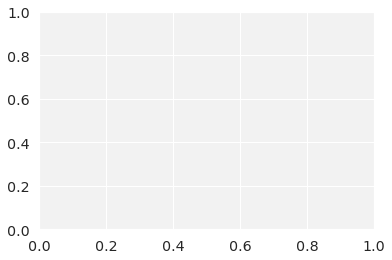

In [42]:
# split-layer align: end of training
EPOCH = 150
last_epoch = barriers[barriers["subdir"].isin(["barrier",
                                               "barrier-bias",
                                                ])]# & (barriers["barrier.epoch"] == EPOCH)]
# last_epoch = barriers[barriers["subdir"].isin(["barrier-endtestonly",
#                                                "barrier-endtestonly-bias",
#                                                 "barrier-endtrainonly",
#                                                 "barrier-endtrainonly-bias"
#                                                 ]) & (barriers["barrier.epoch"] == EPOCH)]
print(last_epoch)


def fixed_values_with_overwrite(df, columns):
    row = {}
    columns_with_differences = set()
    for col in columns:
        item = df[col].iloc[0]
        if isinstance(item, list) and len(item) == 1:
            item = item[0]
        try:
            if len(df[col].unique()) > 1:
                columns_with_differences.add(col)
                # print(f"Warning: column {col} is not unique, taking first element {row[col]}.")
        except:  # hacky way to get around certain datatypes
            columns_with_differences.add(col)
            # print(f"Warning: {col} taking first element {row[col]}.")
        row[col] = item
    return row, columns_with_differences

def make_cols_into_arrays(df, array_cols):
    new_df = []
    cols_with_differences = set()
    for align_bias in [True, False]:
        for train in [True, False]:
            for replicate in df["replicate"].unique():
                group = df[(df["align_bias"] == align_bias) & (df["train"] == train) & (df["replicate"] == replicate)]
                row, cs = fixed_values_with_overwrite(group, [c for c in group.columns if c not in array_cols])
                cols_with_differences = {*cols_with_differences, *cs}
                for col in group.columns:
                    if col in array_cols:
                        item = group[col]
                        if (isinstance(item.iloc[0], list)) and len(item.iloc[0]) == 1:
                            item = item.apply(lambda x: x[0])
                        row[col] = list(item)
                new_df.append(row)
    print(f"Columns overwritten by first element: {cols_with_differences}")
    return pd.DataFrame(new_df)

def get_single_barrier_ep_linestyle(info, fill=False):
    new_info = {k: v for k, v in info.items()}
    new_info["perm.epoch"] = 5
    return get_linestyle(new_info, fill)

layersplit_types = ["bottom-up", "top-down", "put-in", "leave-out"]
for model_name in ["cifar_vgg_16_64"]:   #sorted(last_epoch["model.name"].unique()):
    for layersplit_type in layersplit_types:

        fig = plt.figure()
        ax = plt.subplot(111)
        for threshold_depth in [7]: #sorted(last_epoch["threshold.depth"].unique()):
            subset = last_epoch[(last_epoch["model.name"] == model_name) & (last_epoch["layersplit_type"] == layersplit_type) & (last_epoch["threshold.depth"] == threshold_depth)]
            array_subset = make_cols_into_arrays(subset, ["perm.epoch", "eval_loss", "acc", "loss_barrier", "acc_barrier"])
            plot_info = {
                "xcol": "perm.epoch",
                "ycol": "acc_barrier",
                "xlab": "Rewind epoch",
                "ylab": "Error barrier",
                "ylim": (0, 0.3),
                "summarize_replicates": REPLICATES,
                "styling_fn": get_single_barrier_ep_linestyle,
            }
            plot_barriers(ax, array_subset, **plot_info, train=True, align_bias=True)

        fig = finalize_plot(fig, (2, 2))

# baselines = barriers[barriers["subdir"].isin(["barrier", "barrier-bias"])]
# baselines = baselines.loc[(baselines["layersplit_type"].isin(["final", "ckpt"])) & (baselines["perm.epoch"].isin([10, 150]))]
# super_align = all_epochs.loc[(all_epochs["super_align"])]


In [4]:
# trainonly (testonly) runs only have meaningful train (test) data, so remove the opposite
trainonly_with_test = (barriers["path"].str.contains("trainonly")) & ~(barriers["train"])
barriers = barriers[~(trainonly_with_test)]
testonly_with_train = (barriers["path"].str.contains("testonly")) & (barriers["train"])
barriers = barriers[~(testonly_with_train)]

print(barriers.columns, len(barriers), all_perm_epochs, all_replicates)
for subdir in sorted(barriers["subdir"].unique()):
    print(subdir, len(barriers[barriers["subdir"] == subdir]))

Index(['path', 'interpolation', 'interpolation.idx', 'train', 'perm',
       'perm.epoch', 'replicate', 'layersplit_type', 'threshold',
       'threshold.depth', 'align_bias', 'super_align', 'num_combined', 'model',
       'model.name', 'Unnamed: 0', 'type', 'eval_loss', 'acc', 'loss_barrier',
       'acc_barrier', 'eval_loss.idx', 'acc.idx', 'loss_barrier.idx',
       'acc_barrier.idx', 'barrier', 'barrier.epoch', 'subdir'],
      dtype='object') 3919 [  1   2   3   5   6  10  20  50  80  90 110 150] ['1-2', '3-4', '5-6', '7-8', '9-10']


TypeError: unhashable type: 'list'

                                                  path  interpolation  \
2    /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
3    /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
6    /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
7    /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
14   /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
..                                                 ...            ...   
305  /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
310  /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
311  /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
316  /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   
317  /home/mila/d/devin.kwok/scratch/2022-nnperm/ba...             25   

     interpolation.idx  train       perm  perm.epoch replicate  \
2                   25   True   ep10_it0          10     

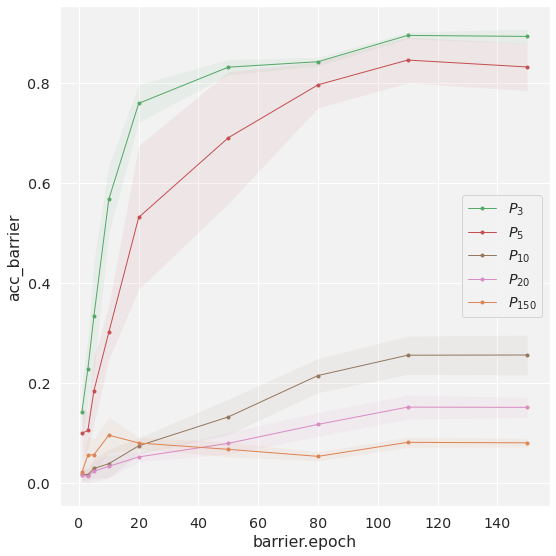

In [43]:
# sanity check: replicate fig 5
baselines = barriers[(barriers["subdir"].isin(["barrier", "barrier-bias"])) & (barriers["layersplit_type"].isin(["final", "ckpt"]))]
print(baselines)
fig = plt.figure()
ax = plt.subplot(111)
# plot_barriers(ax, baselines, "barrier.epoch", "acc_barrier")
plot_barriers(ax, baselines, "barrier.epoch", "acc_barrier", summarize_replicates=REPLICATES, train=True, align_bias=True)
fig = finalize_plot(fig, (2, 2))

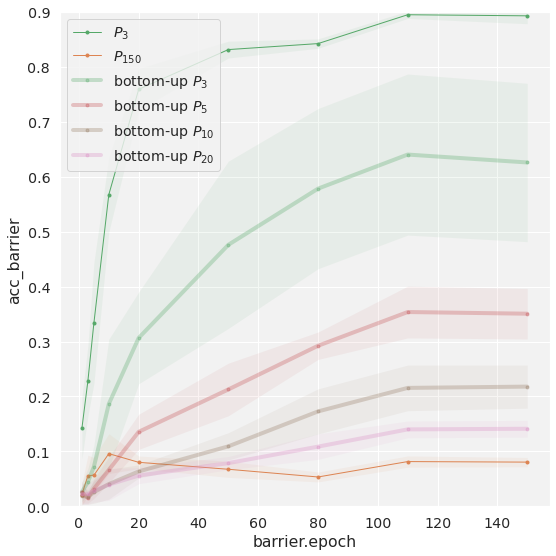

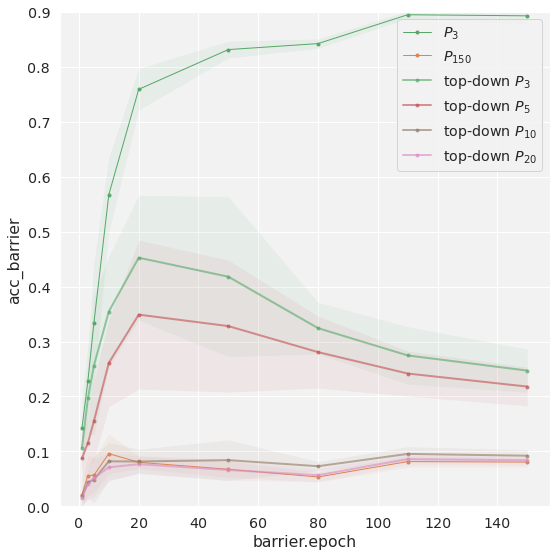

In [45]:
# split-layer align: training trajectory
all_epochs = barriers[barriers["subdir"].isin(["barrier", "barrier-bias"])]
baselines = all_epochs.loc[(all_epochs["layersplit_type"].isin(["final", "ckpt"])) & (all_epochs["perm.epoch"].isin([3, 150]))]
bottom_up = all_epochs.loc[(all_epochs["layersplit_type"] == "bottom-up")]
top_down = all_epochs.loc[(all_epochs["layersplit_type"] == "top-down")]

plot_x = "barrier.epoch"
# plot_y = "eval_loss"
# ylim = (0., 2)
# plot_y = "acc"
# ylim = (0.5, 1)
# plot_y = "loss_barrier"
# ylim = (0., 1)
plot_y = "acc_barrier"
ylim = (0, 0.9)

fig = plt.figure()
ax = plt.subplot(111)
plot_barriers(ax, baselines, "barrier.epoch", plot_y, ylim=ylim, summarize_replicates=REPLICATES, train=True, align_bias=True)
plot_barriers(ax, bottom_up, "barrier.epoch", plot_y, ylim=ylim, summarize_replicates=REPLICATES, train=True, align_bias=True)
fig = finalize_plot(fig, (2, 2))

fig = plt.figure()
ax = plt.subplot(111)
plot_barriers(ax, baselines, "barrier.epoch", plot_y, ylim=ylim, summarize_replicates=REPLICATES, train=True, align_bias=True)
plot_barriers(ax, top_down, "barrier.epoch", plot_y, ylim=ylim, summarize_replicates=REPLICATES, train=True, align_bias=True)
fig = finalize_plot(fig, (2, 2))

No handles with labels found to put in legend.


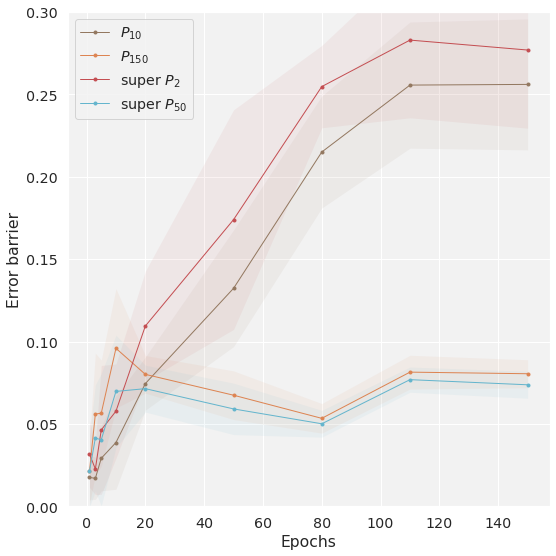

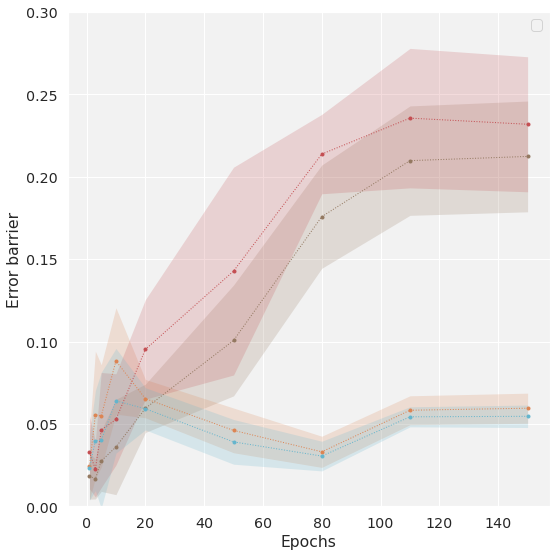

In [51]:
# super-align: training trajectory
baselines = barriers[barriers["subdir"].isin(["barrier", "barrier-bias"])]
baselines = baselines.loc[(baselines["layersplit_type"].isin(["final", "ckpt"])) & (baselines["perm.epoch"].isin([10, 150]))]
all_epochs = barriers[barriers["subdir"].isin(["super-align-barrier", "super-align-barrier-bias"])]
super_align = all_epochs.loc[(all_epochs["super_align"])]

# ycol = "eval_loss"
# ylim = (0., 2)
# ycol = "acc"
# ylim = (0.5, 1)
# ycol = "loss_barrier"
# ylim = (0., 1)
plot_info = {
    "xcol": "barrier.epoch",
    "ycol": "acc_barrier",
    "xlab": "Epochs",
    "ylab": "Error barrier",
    "ylim": (0, 0.3),
    "summarize_replicates": REPLICATES,
    # "styling_fn": lambda x, y: get_linestyle(x, y)
}

fig = plt.figure()
ax = plt.subplot(111)
plot_barriers(ax, baselines, **plot_info, train=True, align_bias=True)
plot_barriers(ax, super_align, **plot_info, train=True, align_bias=True)
fig = finalize_plot(fig, (2, 2))

fig = plt.figure()
ax = plt.subplot(111)
plot_barriers(ax, baselines, **plot_info, train=False, align_bias=True)
plot_barriers(ax, super_align, **plot_info, train=False, align_bias=True)
fig = finalize_plot(fig, (2, 2))


In [44]:
# does bias make a difference? TODO


In [195]:
# see which model interpolation sample the error barrier max/min is from, we can speed up barrier computation by only looking around this area
index_cols = [".idx" in x for x in barriers.columns]

for col in index_cols:
    plt.hist(barriers[col])

KeyError: False